#Prerequisites

In [ ]:
!pip install datasets
!pip install transformers
!pip install ipapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipapy: filename=ipapy-0.0.9.0-py3-none-any.whl size=38721 sha256=4605f28652e746d254b419a4434b3dda1900d59e4a4dc50a9f5551f662f41f75
  Stored in directory: /root/.cache/pip/wheels/54/31/31/21d2360ab8b330654283fc11f9f63dfbd3899576b5925c684a
Successfully built ipapy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display as display
import pickle
import sklearn
from collections import defaultdict
import glob

from tqdm import *
from typing import *

import math
import random

import torch
import torch.nn.functional as F

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from ipapy.ipachar import IPAConsonant
ipa_symbol = IPAConsonant(name="velar nasal", descriptors=u"voiced velar nasal", unicode_repr=u"\u014B")
print(ipa_symbol)

ŋ


In [ ]:
# Mount to drive so we can access our own files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Wav2Vec2

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Model, AutoModel
from datasets import load_dataset

# load FINETUNED model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# # load PRETRAINED model and tokenizer
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")

# put model in evaluation mode
model.eval()
model.to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

#Type 1: /n/ --> [m]

In [ ]:
# clean, tan, own, lean, thin
target_stimuli = ['A1', 'A4', 'A3', 'A5', 'A8']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pn*"):
    if not file.endswith('(1).wav'):
      target_files.append(file)

print(len(target_files))

45


In [ ]:
target_indeces = [97, 103, 93, 32, 31, 30, 45, 48, 45,
                  110, 105, 104, 27, 27, 28, 24, 24, 26,
                  53, 55, 58, 88, 91, 84, 20, 21, 19, 36,
                  37, 38, 52, 56, 58, 115, 117, 109,
                  38, 41, 37, 89, 93, 88, 31, 32, 32]

compensation = [True, True, True, True, True, True, True, True, True,         #clean
                True, True, True, True, True, True, True, True, True,         #own
                False, False, True, False, False, True, False, False, True,   #tan
                True, False, True, True, False, True, True, False, True,      #lean
                True, False, True, True, True, True, False, True, True]       #thin

conditions = ['viable', 'unviable', 'control'] * 15

In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
def get_probs(target_file, target_idx, compensation, condition, wav2vec2_model, wav2vec2_processor, probing_target, underlying_form_idx, lexical_id):

    # Load raw waveform
    raw_waveform, sr = librosa.load(target_file, sr=16000)

    # Tokenize
    input_values = processor(raw_waveform, sampling_rate=16000, return_tensors="pt", padding="max_length", max_length=1000).input_values  # Batch size 1

    # Retrieve logits and hidden states
    output_dict = model(input_values.to(DEVICE), output_hidden_states=True)
    hidden_states = output_dict.hidden_states
    logits = output_dict.logits

    # Get probabilities directly from the logits
    logit_probs = torch.softmax(logits, dim=-1)
    target_prob = logit_probs[0][target_idx][lexical_id].item()
    print(target_prob)

    # Take argmax and decode
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    print(target_file)
    print("Transcription:", transcription)

    # Convert ids to tokens (the model generates frame embeddings and then predicts a token for each embedding)
    predicted_tokens = " ".join(processor.tokenizer.convert_ids_to_tokens(predicted_ids[0].tolist()))
    predicted_tokens_list = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0].tolist())

    # Print target index (and frames surrounding it)
    print(predicted_tokens_list[target_idx-5:target_idx+5])

    # Extract activations corresponding to N from each layer
    for layer_idx, layer_activations in enumerate(hidden_states):
      target_vector = hidden_states[layer_idx][0][target_idx]

      # Run activation through probing model + get probabilities
      X = np.array(target_vector.cpu().detach().numpy())
      loaded_model = pickle.load(open(f'drive/MyDrive/probing_models/finetuned/{probing_target}_probe_{layer_idx+7}.sav', 'rb'))
      probs = loaded_model.predict_proba(X.reshape(1,-1))
      pred = loaded_model.predict(X.reshape(1,-1))

      # Viable stimuli: compensation vs. no compensation
      if condition == 'viable' and compensation == True:
        correct[layer_idx].append(probs[0][underlying_form_idx])
      elif condition == 'viable' and compensation == False:
        incorrect[layer_idx].append(probs[0][underlying_form_idx])

      # Unviable stimuli: compensation vs. no compensation
      elif condition == 'unviable' and compensation == True:
        unv_correct[layer_idx].append(probs[0][underlying_form_idx])
      elif condition == 'unviable' and compensation == False:
        unv_incorrect[layer_idx].append(probs[0][underlying_form_idx])

      # Control stimuli
      elif condition == 'control':
        control[layer_idx].append(probs[0][underlying_form_idx])

    if condition != 'control':
      return target_prob

In [ ]:
target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 'n_m', 1, 9)
  target_probs.append(target_prob)

0.9986101388931274
drive/MyDrive/assimilation/stimA/A1Pn1A9.wav
Transcription: ['PLEASE SARAH CAN YOU HAND ME A CLEAN PAN']
['E', 'E', '<pad>', 'A', '<pad>', 'N', '<pad>', '<pad>', '|', '|']
0.989863932132721
drive/MyDrive/assimilation/stimA/A1Pn1C9.wav
Transcription: ['PLEASE SARAH CAN YOU HAND ME A CLEAN SPOON']
['E', 'E', '<pad>', 'A', '<pad>', 'N', '<pad>', '<pad>', '<pad>', '|']
0.9995226860046387
drive/MyDrive/assimilation/stimA/A1Pn1I9.wav
Transcription: ['PLEASE SARAH CAN YOU HAND ME A CLEAN FORK']
['L', '<pad>', 'E', '<pad>', 'A', 'N', 'N', '<pad>', '<pad>', '|']
0.9976850748062134
drive/MyDrive/assimilation/stimA/A1Pn2A4.wav
Transcription: ["I'M OUT OF CLEAN PAN SO I SHOULD DO THE DISHES"]
['<pad>', 'E', '<pad>', '<pad>', 'A', 'N', '<pad>', '<pad>', '<pad>', '|']
0.998325765132904
drive/MyDrive/assimilation/stimA/A1Pn2C4.wav
Transcription: ['AM AT OF CLEAN SPOONS SO I SHOULD DO THE DISHES']
['<pad>', 'E', 'E', '<pad>', 'A', 'N', '<pad>', '<pad>', '<pad>', '<pad>']
0.997933149

In [ ]:
print(len(target_probs))
print(target_probs)

45
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None]


In [ ]:
strict_freqs = [0, 0, 0, 0, 0, 0, 0, 0, 0,
               31, 160, 1025, 31, 160, 1025, 31, 160, 1025,
               0, 2, 0, 0, 2, 0, 0, 2, 0,
               52, 0, 0, 52, 0, 0, 52, 0, 0,
               3, 0, 1, 3, 0, 1, 3, 0, 1]
loose_freqs = [1, 1, 0, 1, 1, 0, 1, 1, 0,
               183, 162, 1121, 183, 162, 1121, 183, 162, 1121,
               0, 2, 0, 0, 2, 0, 0, 2, 0,
               57, 1, 84, 57, 1, 84, 57, 1, 84,
               3, 0, 1, 3, 0, 1, 3, 0, 1]

In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

11 4 8 7 15


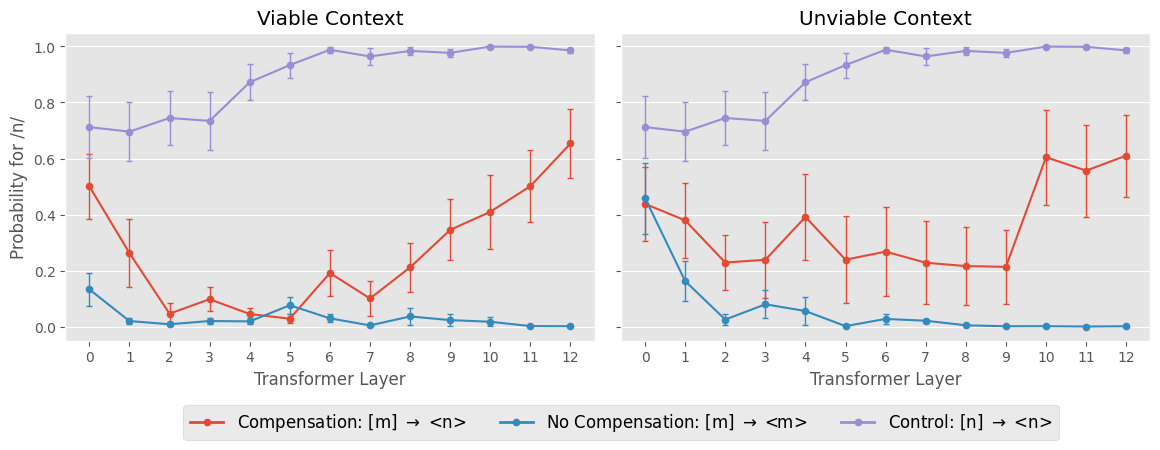

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,incorrect_avg,incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.grid(False, axis='x')

ax2.errorbar(x,unv_correct_avg,unv_correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem, fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_ylabel('Probability for /n/')

ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[r'Compensation: [m] $\rightarrow$ <n>', r'No Compensation: [m] $\rightarrow$ <m>', r'Control: [n] $\rightarrow$ <n>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
#plt.savefig('probing-n-m.pdf', dpi=300, bbox_inches='tight')

#Type 2: /n/ --> [ng]

In [ ]:
from ipapy.ipachar import IPAConsonant

In [ ]:
ipa_symbol = IPAConsonant(name="velar nasal", descriptors=u"voiced velar nasal", unicode_repr=u"\u014B")
print(ipa_symbol)

ŋ


In [ ]:
import glob
# green, plain, fun --> greeng, plaing, fung
target_stimuli = ['A2', 'A6', 'A7']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pn*"):
    if not file.endswith('(1).wav'):
      target_files.append(file)

print(len(target_files))

27


In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
target_indeces = [51, 56, 54, 85, 83, 85, 67, 75, 70,
                  83, 79, 58, 59, 60, 72, 72, 66, 83,
                  75, 74, 73, 121, 115, 119, 43, 42, 44]

compensation = [True, True, True, True, True, True, True, True, True,
                False, True, False, False, True, False, False, True, False,
                False, False, True, True, False, True, True, False, True]

conditions = ['viable', 'unviable', 'control', 'viable', 'unviable', 'control', 'viable', 'unviable', 'control',
              'unviable', 'control', 'viable', 'unviable', 'control', 'viable', 'viable', 'control', 'unviable',
              'viable', 'unviable', 'control', 'viable', 'unviable', 'control', 'viable', 'unviable', 'control']

In [ ]:
#target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 'n_ng', 0, 9)
  target_probs.append(target_prob)

0.9743708372116089
Transcription: ['SHE BOUGHT THIS NEW GREEN CUP IN ANTUCKET LAST SUMMER']
['E', '<pad>', '<pad>', '<pad>', 'E', 'N', 'N', '<pad>', '<pad>', '|']
0.9960143566131592
Transcription: ['SHE BOUGHT THIS NEW GREEN CHAIR IN NANTUCKETT LAST SUMMER']
['E', '<pad>', '<pad>', '<pad>', 'E', 'N', 'N', '<pad>', '<pad>', '|']
0.9999579191207886
Transcription: ['SHE BOUGHT THIS NEW GREEN VASE IN NANTUCKETT LAST SUMMER']
['E', '<pad>', '<pad>', '<pad>', 'E', 'N', '<pad>', '<pad>', '|', '|']
0.9996955394744873
Transcription: ["MY SUN BROKE MY NEIGHBOUR'S NEW GREEN CUP"]
['E', '<pad>', '<pad>', 'E', '<pad>', 'N', '<pad>', '<pad>', '|', '|']
0.9987602233886719
Transcription: ["MY SON BROKE MY NEIGHBOUR'S NEW GREEN CHAIR"]
['<pad>', 'E', '<pad>', '<pad>', 'E', 'N', 'N', '<pad>', '<pad>', '|']
0.9997832179069519
Transcription: ["MY SUN BROKE MY NEIGHBOUR'S NEW GREEN VASE"]
['E', '<pad>', '<pad>', '<pad>', 'E', 'N', 'N', '<pad>', '<pad>', '|']
0.9981614947319031
Transcription: ['THE COLLAR O

In [ ]:
print(len(target_probs))
print(target_probs)

72
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None, 0.9743708372116089, 0.9960143566131592, None, 0.9996955394744873, 0.9987602233886719, None, 0.9981614947319031, 0.999653697013855, None, 0.998975396156311, None, 0.9998001456260681, 0.9937986731529236, None, 0.9992913007736206, 0.9999094009399414, None, 0.9992884397506714, 0.999947190284

In [ ]:
strict_freqs.extend([0, 5, 3, 0, 5, 3, 0, 5, 3,
               0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0])
loose_freqs.extend([5, 7, 4, 5, 7, 4, 5, 7, 4,
               0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(len(strict_freqs), len(loose_freqs))

72 72


In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

5 4 3 6 9


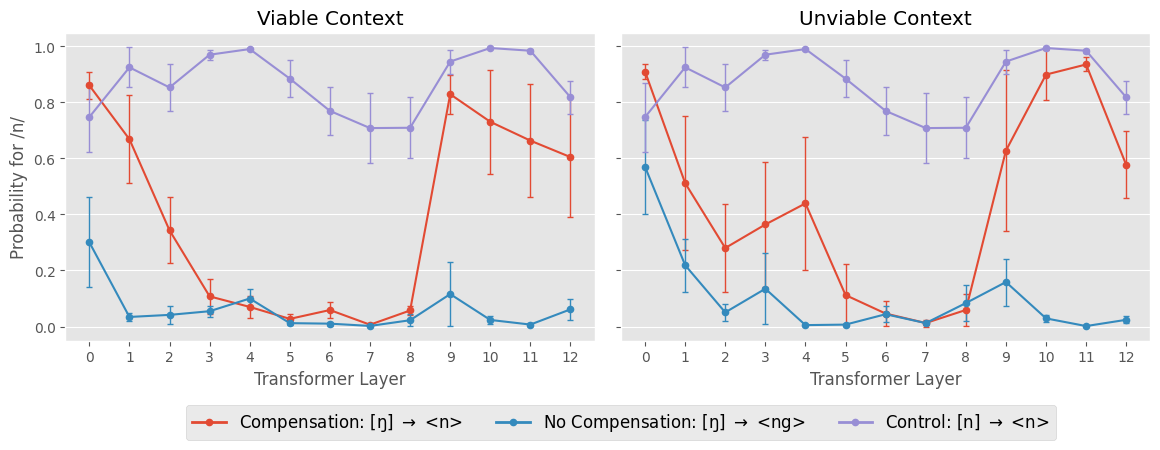

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,incorrect_avg,incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.grid(False, axis='x')

ax2.errorbar(x,unv_correct_avg,unv_correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_ylabel('Probability for /n/')

ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[f'Compensation: [{ipa_symbol}] ' + r'$\rightarrow$ <n>', f'No Compensation: [{ipa_symbol}] ' + r'$\rightarrow$ <ng>', f'Control: [n] ' + r'$\rightarrow$ <n>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
plt.savefig('probing-n-ng.pdf', dpi=300, bbox_inches='tight')

#Type 3: /t/ --> [k]

In [ ]:
# great, sweet --> greak, sweek
target_stimuli = ['A6', 'A8']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pt*"):
    if not file.endswith('(1).wav'):
      target_files.append(file)

print(len(target_files))

18


In [ ]:
target_indeces = [61, 62, 65, 49, 51, 47, 107, 112, 107,
                  71, 74, 72, 25, 22, 21, 95, 98, 92]

compensation = [True, False, True, True, True, True, True, False, True,   #great
                False, True, True, False, True, True, True, True, True]   #sweet

conditions = ['viable', 'unviable', 'control', 'viable', 'unviable', 'control', 'viable', 'unviable', 'control',
              'unviable', 'viable', 'control', 'unviable', 'viable', 'control', 'viable', 'unviable', 'control']

In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
#target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 't_k', 1, 6)
  target_probs.append(target_prob)

0.9925644993782043
Transcription: ['I THOUGHT THAT WAS A REALLY GREAT CRUISE WHAT DID YOU THINK']
['<pad>', 'E', '<pad>', 'A', '<pad>', 'T', '<pad>', '|', '<pad>', '<pad>']
0.24907733500003815
Transcription: ['I THOUGHT THAT WAS A REALLY GREAK MATCH WHAT DID YOU THINK']
['E', '<pad>', '<pad>', 'A', '<pad>', 'K', '<pad>', '<pad>', '|', '|']
0.994468092918396
Transcription: ['I THOUGHT THAT WAS A REALLY GREAT FIGHT WHAT DID YOU THINK']
['R', 'E', 'E', 'A', '<pad>', 'T', 'T', '<pad>', '|', '|']
0.9954415559768677
Transcription: ["IT WOULD HAVE BEEN A GREAT CRUISE IF IT HADN'T RAINED"]
['<pad>', 'E', '<pad>', 'A', '<pad>', 'T', '<pad>', '|', '<pad>', '<pad>']
0.7943904399871826
Transcription: ["IT WOULD HAVE BEEN A GREAT MATCH IF IT HADN'T RAINED"]
['<pad>', 'E', '<pad>', 'A', '<pad>', 'T', '<pad>', '<pad>', '|', '|']
0.9996993541717529
Transcription: ["IT WOULD HAVE BEEN A GREAT FIGHT IF IT HADN'T RAINED"]
['<pad>', 'E', 'A', 'A', '<pad>', 'T', '<pad>', '|', '|', '<pad>']
0.98752439022064

In [ ]:
print(len(target_probs))
print(target_probs)

90
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None, 0.9743708372116089, 0.9960143566131592, None, 0.9996955394744873, 0.9987602233886719, None, 0.9981614947319031, 0.999653697013855, None, 0.998975396156311, None, 0.9998001456260681, 0.9937986731529236, None, 0.9992913007736206, 0.9999094009399414, None, 0.9992884397506714, 0.999947190284

In [ ]:
strict_freqs.extend([0, 40, 80, 0, 40, 80, 0, 40, 80,
                2, 0, 2, 2, 0, 2, 0, 2, 2])
loose_freqs.extend([1, 43, 115, 1, 43, 115, 1, 43, 115,
               2, 0, 3, 2, 0, 3, 0, 2, 3])

In [ ]:
print(len(strict_freqs), len(loose_freqs))

90 90


In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

6 0 2 4 6


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


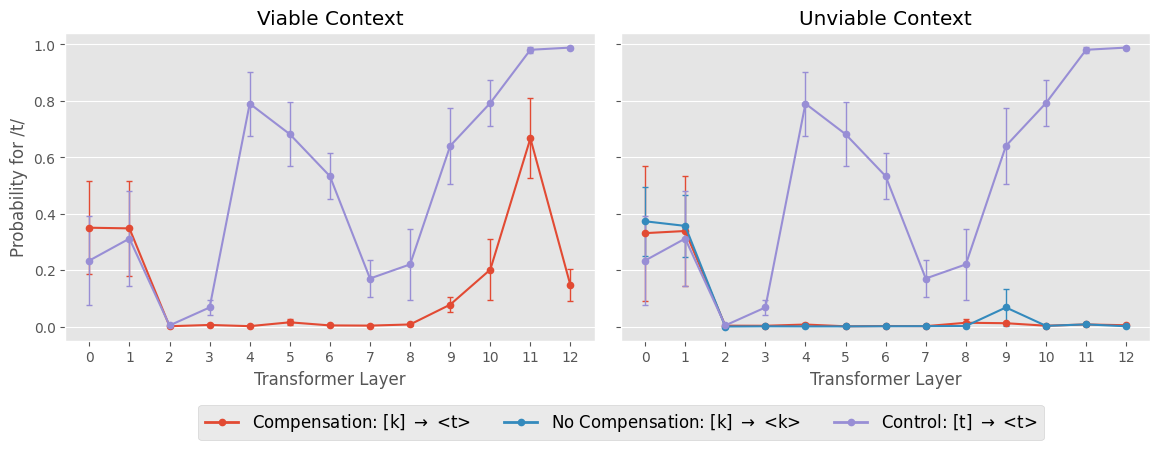

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#E24A33')
#ax1.errorbar(x,incorrect_avg,incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#988ED5')
ax1.grid(False, axis='x')

ax2.errorbar(x,unv_correct_avg,unv_correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_ylabel('Probability for /t/')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[r'Compensation: [k] $\rightarrow$ <t>', r'No Compensation: [k] $\rightarrow$ <k>', r'Control: [t] $\rightarrow$ <t>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
#plt.savefig('probing-t-k.pdf', dpi=300, bbox_inches='tight')

#Type 4: /t/ --> [p]

In [ ]:
# fat, wet --> fap, wep (A5, A7)
target_stimuli = ['A5', 'A7']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pt*"):
    if not file.endswith('(1).wav') and not file.endswith('(2).wav'):
      target_files.append(file)

print(len(target_files))

18


In [ ]:
target_indeces = [50, 52, 48, 94, 102, 99, 30, 34, 31,
                  53, 50, 54, 96, 97, 89, 33, 31, 30]

compensation = [True, True, True, True, False, True, True, True, True,    #fat
                True, False, True, False, True, True, True, True, True]   #wet

conditions = ['viable', 'unviable', 'control'] * 6

In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
#target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 't_p', 1, 6)
  target_probs.append(target_prob)

0.9983124732971191
Transcription: ['THAT STORY ABOUT A FAT PUPPY WAS MY FAVORITE CHILDHOOD BOOK']
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'T', '<pad>', '|', '|', '<pad>']
0.7805486917495728
Transcription: ['THAT STORY ABOUT A FAT SQUIRREL WAS MY FAVORITE CHILDHOOD BOOK']
['<pad>', 'A', '<pad>', '<pad>', '<pad>', 'T', '<pad>', '<pad>', '<pad>', '|']
0.9999097585678101
Transcription: ['THAT STORY ABOUT A FAT MONKEY WAS MY FAVORITE CHILDHOOD BOOK']
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'T', '<pad>', '|', '|', '<pad>']
0.9982782602310181
Transcription: ['Y KIDS LOVE THAT MOVY ABOUT THE FAT PUPPY AND  THIN RABBIT']
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'T', '<pad>', '|', '<pad>', '<pad>']
0.4585561156272888
Transcription: ['Y KIDS LOVE THAT MOVY ABOUT THE FAP SQUIRREL AND THE THIN RABBIT']
['<pad>', 'A', '<pad>', '<pad>', '<pad>', 'P', '<pad>', '<pad>', '<pad>', '|']
0.9997393488883972
Transcription: ['Y KIDS LOVE AT MOVY ABOUT THE FAT MONKEY AND THE THIN RABBIT']
['<pad>', 'A', '

In [ ]:
print(len(target_probs))
print(target_probs)

108
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None, 0.9743708372116089, 0.9960143566131592, None, 0.9996955394744873, 0.9987602233886719, None, 0.9981614947319031, 0.999653697013855, None, 0.998975396156311, None, 0.9998001456260681, 0.9937986731529236, None, 0.9992913007736206, 0.9999094009399414, None, 0.9992884397506714, 0.99994719028

In [ ]:
strict_freqs.extend([1,1,1,1,1,1,1,1,1,
               0,1,11,0,1,11,0,1,11])
loose_freqs.extend([1,1,1,1,1,1,1,1,1,
               0,1,11,0,1,11,0,1,11])

In [ ]:
print(len(strict_freqs), len(loose_freqs))

108 108


In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

5 1 4 2 6


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


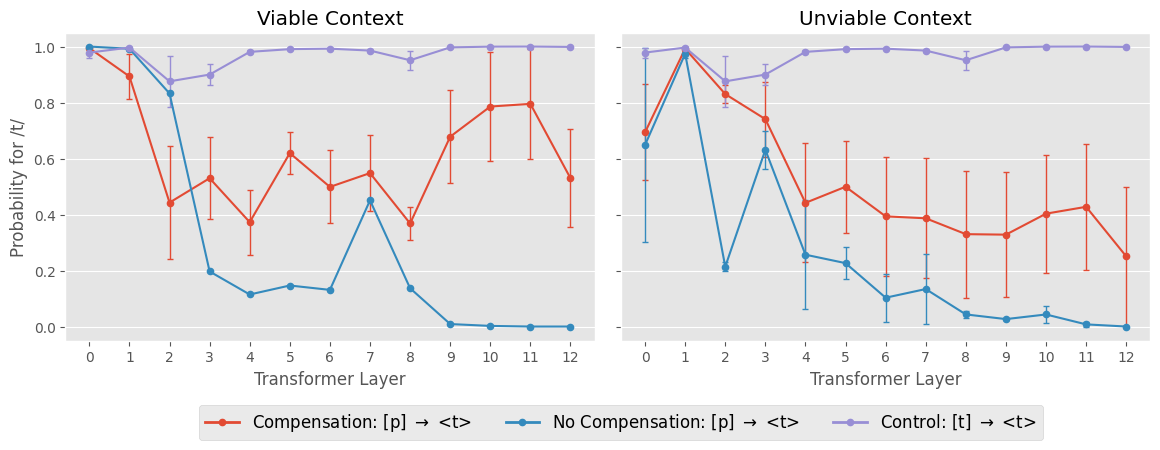

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,incorrect_avg,None,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.grid(False, axis='x')

ax2.errorbar(x,unv_correct_avg,unv_correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_ylabel('Probability for /t/')

ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[r'Compensation: [p] $\rightarrow$ <t>', r'No Compensation: [p] $\rightarrow$ <t>', r'Control: [t] $\rightarrow$ <t>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
#plt.savefig('probing-t-p.pdf', dpi=300, bbox_inches='tight')

#Type 5: /d/ --> [b]

In [ ]:
import glob

# mad, sad, bad --> mab, sab, bab
target_stimuli = ['A1', 'A2', 'A4']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pd*"):
    if not file.endswith('(1).wav'):
      target_files.append(file)

print(len(target_files))

27


In [ ]:
target_indeces = [100, 98, 100, 123, 122, 125, 84, 84, 86,
                  66, 67, 65, 19, 19, 18, 27, 27, 28,
                  139, 137, 137, 152, 154, 145, 127, 139, 122]

compensation = [True, True, False, False, True, True, True, True, False,      #mad
                False, False, True, False, False, True, False, False, True,   #sad
                True, False, True, True, True, True, True, True, True]        #bad

conditions = ['viable', 'control', 'unviable', 'unviable', 'viable', 'control', 'viable', 'control', 'unviable',
              'viable', 'unviable', 'control', 'viable', 'unviable', 'control','viable', 'unviable', 'control',
              'viable', 'unviable', 'control', 'viable', 'unviable', 'control','viable', 'unviable', 'control']

In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
#target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 'd_b', 1, 14)
  target_probs.append(target_prob)

0.9024166464805603
Transcription: ["I DON'T WANT TO GO HOME TO FACE MY MAD BROTHER"]
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'D', '<pad>', '<pad>', '|', '|']
0.9998685121536255
Transcription: ["I DON'T WANT TO GO HOME TO FACE MY MAD MOTHER"]
['<pad>', 'A', '<pad>', '<pad>', '<pad>', 'D', '<pad>', '|', '|', '<pad>']
2.54817077802727e-05
Transcription: ["I DON'T WANT TO GO HOME TO FACE MY MAPP DAUGHTER"]
['<pad>', 'M', '<pad>', '<pad>', 'A', 'P', '<pad>', '<pad>', 'P', '<pad>']
0.15180368721485138
Transcription: ['AFTER CRASHING THE FAMILY CAR I HAD A VERY MAB DAUGHTER']
['<pad>', 'A', '<pad>', '<pad>', '<pad>', 'B', '<pad>', '<pad>', '<pad>', '|']
0.9976710677146912
Transcription: ['AFTER CRASHING THE FAMILY CAR I HAD A VERY MAD BROTHER']
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'D', '<pad>', '<pad>', '|', '|']
0.9999821186065674
Transcription: ['AFTER CRASHING THE FAMILY CAR I HAD A VERY MAD MOTHER']
['<pad>', '<pad>', 'A', '<pad>', '<pad>', 'D', '<pad>', '|', '|', '<pad>']
0.750142

In [ ]:
print(len(target_probs))
print(target_probs)

135
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None, 0.9743708372116089, 0.9960143566131592, None, 0.9996955394744873, 0.9987602233886719, None, 0.9981614947319031, 0.999653697013855, None, 0.998975396156311, None, 0.9998001456260681, 0.9937986731529236, None, 0.9992913007736206, 0.9999094009399414, None, 0.9992884397506714, 0.99994719028

In [ ]:
strict_freqs.extend([0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,
               11,0,0,11,0,0,11,0,0])
loose_freqs.extend([0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,
               11,0,1,11,0,1,11,0,1])

In [ ]:
print(len(strict_freqs), len(loose_freqs))

135 135


In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

6 3 2 7 9


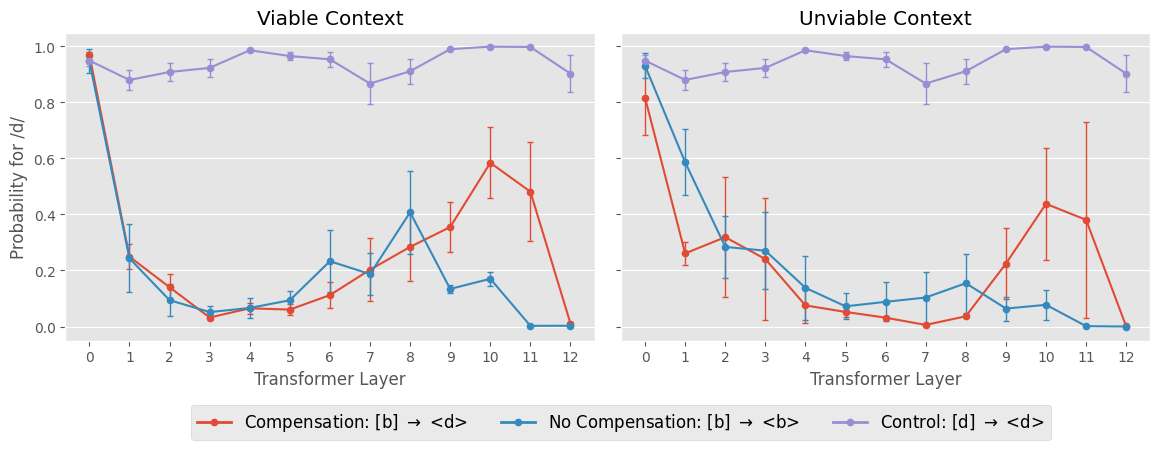

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,incorrect_avg,incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.grid(False, axis='x')

ax2.errorbar(x,unv_correct_avg,unv_correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_ylabel('Probability for /d/')
#fig.text(0.5, -0.03, 'Transformer Layer', ha='center')

# # # add a big axis, hide frame
# fig.add_subplot(111, frameon=False)
# # # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False, gridOn=False)
ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[r'Compensation: [b] $\rightarrow$ <d>', r'No Compensation: [b] $\rightarrow$ <b>', r'Control: [d] $\rightarrow$ <d>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
#plt.savefig('probing-d-b.pdf', dpi=300, bbox_inches='tight')

#Type 6: /d/ --> [g]

In [ ]:
import glob

# red --> reg
target_stimuli = ['A3']
target_files = []
for target in target_stimuli:
  for file in glob.glob(f"drive/MyDrive/assimilation/stimA/{target}Pd*"):
    if not file.endswith('(1).wav'):
      target_files.append(file)

print(len(target_files))

9


In [ ]:
target_indeces = [18, 18, 17, 103, 94, 67, 71, 61, 101]

compensation = [True, False, True, False, True, True, False, True, True]

conditions = ['viable', 'unviable', 'control', 'unviable', 'control', 'viable', 'unviable', 'control', 'viable']

In [ ]:
num_layers = 13

# Here we will store the probabilities for the viable stimuli (compensated vs. not compensated)
correct = {layer_idx: [] for layer_idx in range(num_layers)}
incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the unviable stimuli (compensated vs. not compensated)
unv_correct = {layer_idx: [] for layer_idx in range(num_layers)}
unv_incorrect = {layer_idx: [] for layer_idx in range(num_layers)}

# Here we will store the probabilities for the control stimuli
control = {layer_idx: [] for layer_idx in range(num_layers)}

In [ ]:
#target_probs = []
for file, idx, comp, cond in zip(target_files, target_indeces, compensation, conditions):
  target_prob = get_probs(file, idx, comp, cond, model, processor, 'd_g', 0, 14)
  target_probs.append(target_prob)

0.9853923916816711
Transcription: ['THOSE RED GLASSES AD A NICE TOUCH TO YOUR BLACK OUTFIT']
['R', '<pad>', 'E', '<pad>', '<pad>', 'D', '<pad>', '|', '|', '<pad>']
0.042733095586299896
Transcription: ['T REG LIP STICKAS A NICE TOUCH TO YOUR BLACK OUTFIT']
['<pad>', 'E', '<pad>', '<pad>', '<pad>', 'G', '<pad>', '<pad>', '|', '<pad>']
0.9988225102424622
Transcription: ['THAT RED NECKLACE AS A NICE TOUCHED YOUR BLACK OUTFIT']
['R', 'E', '<pad>', '<pad>', '<pad>', 'D', '<pad>', '|', '<pad>', '<pad>']
0.24288222193717957
Transcription: ["YOU'RE TOO PALE TO WEAR THAT FLASHY REG LIPSTICK"]
['R', 'E', '<pad>', '<pad>', '<pad>', 'G', '<pad>', '<pad>', '|', '<pad>']
0.9998592138290405
Transcription: ["YOU'RE TOO PALE TO WEAR THAT FLASHY RED NECKLACE"]
['R', '<pad>', 'E', '<pad>', '<pad>', 'D', '<pad>', '|', '|', '<pad>']
0.9610888361930847
Transcription: ['I ALREADY LOST MY NEW RED GLASSES THAT I JUST BOUGHT']
['R', '<pad>', 'E', '<pad>', '<pad>', 'D', '<pad>', '<pad>', '|', '|']
0.0001333201362

In [ ]:
print(len(target_probs))
print(target_probs)

144
[0.9986101388931274, 0.989863932132721, None, 0.9976850748062134, 0.998325765132904, None, 0.9968446493148804, 0.9536221623420715, None, 0.9986024498939514, 0.9995331764221191, None, 0.7980812191963196, 0.9702993035316467, None, 0.9999641180038452, 0.9998816251754761, None, 0.027161357924342155, 0.005231255665421486, None, 0.05534565821290016, 0.005985786207020283, None, 0.009532990865409374, 0.0009502042667008936, None, 0.9941315054893494, 0.08238524943590164, None, 0.9732580184936523, 0.21382129192352295, None, 0.9971101880073547, 0.00027617806335911155, None, 0.5666154623031616, 0.16478097438812256, None, 0.8439241647720337, 0.5146711468696594, None, 0.23374702036380768, 0.6332941055297852, None, 0.9743708372116089, 0.9960143566131592, None, 0.9996955394744873, 0.9987602233886719, None, 0.9981614947319031, 0.999653697013855, None, 0.998975396156311, None, 0.9998001456260681, 0.9937986731529236, None, 0.9992913007736206, 0.9999094009399414, None, 0.9992884397506714, 0.99994719028

In [ ]:
strict_freqs.extend([0, 0, 0, 0, 0, 0, 0, 0, 0])
loose_freqs.extend([12, 0, 2, 0, 2, 12, 0, 2, 12])

In [ ]:
print(len(strict_freqs), len(loose_freqs))

144 144


In [ ]:
print(len(correct[0]), len(incorrect[0]), len(unv_correct[0]), len(unv_incorrect[0]), len(control[0]))

# Get average probability for each layer (average over stimuli)
correct_avg = [np.mean(value) for value in correct.values()]
incorrect_avg = [np.mean(value) for value in incorrect.values()]
unv_correct_avg = [np.mean(value) for value in unv_correct.values()]
unv_incorrect_avg = [np.mean(value) for value in unv_incorrect.values()]
control_avg = [np.mean(value) for value in control.values()]

from scipy.stats import sem

# Get standard error
correct_sem = [sem(value) for value in correct.values()]
incorrect_sem = [sem(value) for value in incorrect.values()]
unv_correct_sem = [sem(value) for value in unv_correct.values()]
unv_incorrect_sem = [sem(value) for value in unv_incorrect.values()]
control_sem = [sem(value) for value in control.values()]

3 0 0 3 3


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


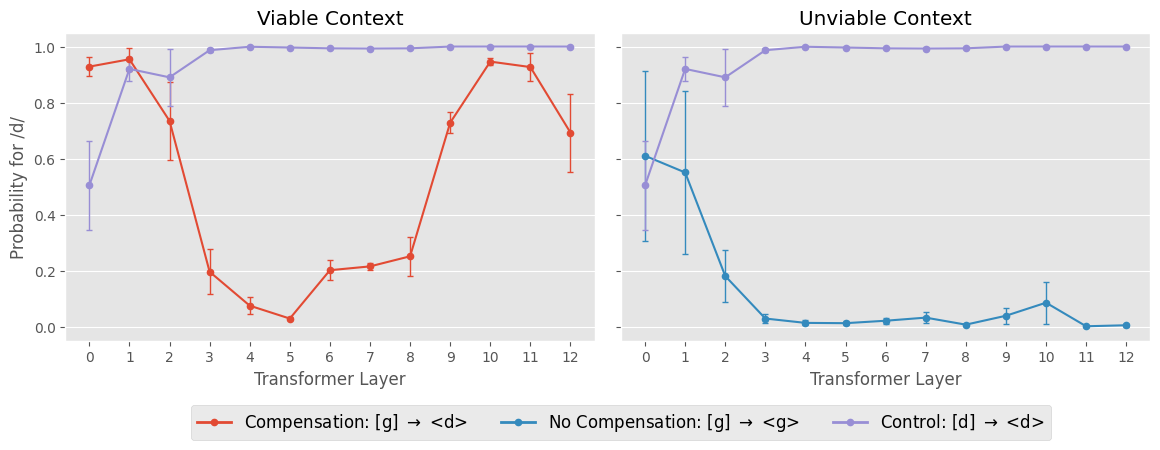

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,4))

gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

x=range(13)

ax1.errorbar(x,correct_avg,correct_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#E24A33')
#ax1.errorbar(x,incorrect_avg,incorrect_std,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax1.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#988ED5')
ax1.grid(False, axis='x')

#ax2.errorbar(x,unv_correct_avg,unv_correct_std,fmt='.-',capsize=2,elinewidth=1, markersize=9)
ax2.errorbar(x,unv_incorrect_avg,unv_incorrect_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#348ABD')
ax2.errorbar(x,control_avg,control_sem,fmt='.-',capsize=2,elinewidth=1, markersize=9, color='#988ED5')
ax2.grid(False, axis='x')

ax1.set_xticks(range(13), range(13))
ax2.set_xticks(range(13), range(13))

ax1.set_ylabel('Probability for /d/')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax1.set_xlabel('Transformer Layer')
ax2.set_xlabel('Transformer Layer')

ax1.set_title('Viable Context')
ax2.set_title('Unviable Context')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='.', color='#E24A33', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#348ABD', lw=2, markersize=9),
                   Line2D([0], [0], marker='.', color='#988ED5', lw=2, markersize=9)]

plt.legend(handles=legend_elements, labels=[r'Compensation: [g] $\rightarrow$ <d>', r'No Compensation: [g] $\rightarrow$ <g>', r'Control: [d] $\rightarrow$ <d>'], loc='lower center', bbox_to_anchor=(0, -0.35), ncol=3, fontsize=12)
#plt.savefig('probing-d-g.pdf', dpi=300, bbox_inches='tight')

#Correlation between bigram frequency & output probability

In [ ]:
final_freqs, final_probs = [], []
for freq, prob in zip(loose_freqs, target_probs):
  if prob != None:
    final_freqs.append(freq)
    final_probs.append(prob)
print(len(final_freqs), len(final_probs))

96 96


In [ ]:
import scipy
scipy.stats.spearmanr(final_freqs, final_probs)

SignificanceResult(statistic=0.16420907250090286, pvalue=0.10988497838779716)